# Twitter Classifier

## Abstract
For this project, I will be using tweets and natural language processing (NLP) to build classification models through supervised and unsupervised learning.  I pull the most recent 3200 tweets (as of May 28, 2018) from four twitter handles (realDonaldTrump, junstinbieber, hillaryclinton, and katyperry) to perform my analysis.  

First, I use Bag of Words to build features and perform supervised learning models.  Multinomial Logistic Regression performed the best with the highest accuracies.  Justin Bieber tweets had the lowest sensitivity and accuracy across all models, while Trump had the highest sensitivity and accuracy for Random Forest and Multinomial Logistic Regression.  

I then use tfidf to convert the tweets into vectors, reduce the vectors to two components using Singular Value Decomposition, and generate visual clusters using k-means and mean-shift.  I found that most of the tweets, regardless of the tweeter, seem to be concentrated in one cluster.  Interestingly, when generating 3 or 4 clusters, Hillary Clinton and Donald Trump would make up the majority of one of the clusters.  My theory is that this is the "politics" cluster.  To get a better look at cluster topics, I used Latent Semantic Analysis (LSA).  I exapanded the tfidf feature space to 200 components, and examine the top 10 clusters of terms that reflect a topic.  LSA create three clusters of "Thank you" tweets, two clusters of "love" tweets, and one cluster of "lol" tweets.  There was also a Donald Trump cluster, a "#PURPOSE" cluster (Justin Bieber's new album), and an American Idol cluster (Katy Perry is a judge).

Lastly I generated a word2vec model, the most common neural network approach for NLP.  word2vec is a way of "teaching" a machine human language, in this case through tweets.  We can then look at the similarities between words.  In order to run word2vec, I expanded the corpus to include five more twitter handles.  However, word2vec works best with a corpus that is at least several billion words long (beyond the limitation of my computer), so the model is not great.  



# Table of Contents
- [Introduction](#intro)
    - Models
- [Imports](#imports)
- [Accessing and Cleaning Tweets](#tweets)
- [Supervised Learning](#SL)
    - [Random Forest](#forest)
    - [Multinomial Logistic Regression](#log)
    - [Gradient Boost](#boost)
    - [SVM](#svm)
    - [Conclusion](#conclude)
- [Unsupervised Learning](#SL)
    - [K-Means Clusters](#kmeans)
    - [Mean-Shift Clusters](#meansshift)
    - [Latent Semantic Analysis](#lsa)
    - [Conclusion](#conclude2)
- [Word2Vec](#word)
- [Conclusion](#conclude3)

<a id='intro'></a>
# Introduction
For this project, I will be using tweets and natural language processing (NLP) to build classification models.  I am pulling the most recent ~3200 tweets (run date: May 25, 2018) from four twitter handles: realDonaldTrump, junstinbieber, hillaryclinton, and katyperry.  I will then be using a variety of supervised and unsupervised models to group and cluster the tweets in various ways.

## Models
First, I will be using supervised learning to train the model to correctly identify the tweeter from the tweet.  I use Bag of Words to contruct the feature space, and then I run Random Forest, Multinomial Logistic Regression, Gradient Boost, and Support Vector Machine to classify the tweets and compare the models for accuracy.

Next, I will convert the tweets into vectors using tfidf and use these vectors to create unsupervised k-means clusters.  Then, I will apply Latent Semantic Analysis, a process of applying PCA to a tfidf term-document matrix to generate clusters of terms that presumably reflect a topic.

Lastly, I will play around with word2vec, the most common unsupervised neural network approach for NLP.  I expand on the corpus to include tweets from Ellen Degeneres, Barack Obama, Rihanna, Senator John Mccain, and Pope Francis.  I use the model to identify similarities between words and emojis.    

<a id='imports'></a>
# Imports

In [1]:
import tweepy

%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import normalize
from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Twitter API Authorizations
consumer_key = '9SRz5HMehrEVQf2m7AoN4shrq'
consumer_secret = 'zZa9j55quKFTmTwm4PKx4B6RUn3OyCsEtVJmvqbLAX9d8K3Adu'
access_token = '2801486303-55EJTjYXUPvw5uzXmRQV8wTHDmiLh70BJoASUj9'
access_token_secret = 'aRGfnR8N4if56loNt0yhwChXBe61go8qTpEanmXV2RBRp'

<a id='tweets'></a>
# Accessing and Cleaning Tweets

In [2]:
# Thank you, yanofsky! Adapted from: https://gist.github.com/yanofsky/5436496

def get_all_tweets(screen_names):

    #authorize twitter, initialize tweepy
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)

    
    #initialize a list to hold all the tweepy Tweets
    df = pd.DataFrame()
    
    for screen_name in screen_names:
        
        alltweets = []

        #make initial request for most recent tweets (200 is the maximum allowed count)
        new_tweets = api.user_timeline(screen_name = screen_name ,count=200)

        #save most recent tweets
        alltweets.extend(new_tweets)

        #save the id of the oldest tweet less one
        oldest = alltweets[-1].id - 1

        #keep grabbing tweets until there are no tweets left to grab
        while len(new_tweets) > 0:
            print("getting tweets before %s" % (oldest))

            #all subsiquent requests use the max_id param to prevent duplicates
            new_tweets = api.user_timeline(screen_name = screen_name,count=200,max_id=oldest)

            #save most recent tweets
            alltweets.extend(new_tweets)

            #update the id of the oldest tweet less one
            oldest = alltweets[-1].id - 1

            print("...%s tweets downloaded so far" % (len(alltweets)))

        #transform the tweepy tweets into a 2D array that will populate the csv	
        outtweets = [[tweet.user.screen_name, tweet.text] for tweet in alltweets]

        df = df.append(pd.DataFrame(data=outtweets)).reset_index(drop=True)
        
    return df
    
    print('done!')

These twitter accounts were chosen with some trial and error.  Since we are only allowed to pull tweets from the last week or so, I wanted to make sure to get prolific tweeters in the dataset.  That way we have a well balanced dataset.

In [3]:
# Getting the most recent 3200 tweets from Donald Trump, Justin Bieber, Hillary Clinton, 
# and Katy Perry.
tweets = get_all_tweets(['realDonaldTrump','justinbieber','hillaryclinton','katyperry'])

getting tweets before 992083738531192832
...400 tweets downloaded so far
getting tweets before 984015782521835520
...600 tweets downloaded so far
getting tweets before 971009285181276159
...800 tweets downloaded so far
getting tweets before 959488037766955008
...1000 tweets downloaded so far
getting tweets before 948202173049049087
...1200 tweets downloaded so far
getting tweets before 936555753946705919
...1397 tweets downloaded so far
getting tweets before 927077305876434944
...1597 tweets downloaded so far
getting tweets before 920406959320371199
...1796 tweets downloaded so far
getting tweets before 913004378486984703
...1996 tweets downloaded so far
getting tweets before 905770927526432767
...2196 tweets downloaded so far
getting tweets before 896431205549318143
...2396 tweets downloaded so far
getting tweets before 888088029428150271
...2596 tweets downloaded so far
getting tweets before 878341007103987711
...2795 tweets downloaded so far
getting tweets before 865957909565366271


In [4]:
tweets[0].value_counts()

realDonaldTrump    3234
katyperry          3217
HillaryClinton     3215
justinbieber       3170
Name: 0, dtype: int64

Great! We have about 3200 tweets from each twitter account.  Having a balanced dataset will make the predictive models more accurate. 

In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12836 entries, 0 to 12835
Data columns (total 2 columns):
0    12836 non-null object
1    12836 non-null object
dtypes: object(2)
memory usage: 200.6+ KB


In [6]:
# Naming the columns
tweets.columns = ['screenname','tweet']

In [7]:
# Changing tweets to str types.
tweets['tweet'] = tweets['tweet'].astype(str)

Let's clean the tweets to remove links and drop tweets that are retweets.

In [8]:
def text_cleaner(tweet):
    tweet = re.sub(r'http.*','',tweet)
    tweet = re.sub(r'bit/ly.*', "", tweet)
    tweet = re.sub(r'b\'', "", tweet)
    tweet = re.sub(r'b"', "", tweet)
    return tweet

In [9]:
for r in range(len(tweets['tweet'])):
    tweets['tweet'][r] = text_cleaner(tweets['tweet'][r])

#Dropping retweets    
tweets = tweets[tweets['tweet'].str.contains("RT") == False].reset_index(drop=True)
    

Now to parse the tweens using spacy.

Helpful link about disabling piplines to make nlp run faster: https://spacy.io/usage/processing-pipelines#disabling

In [10]:
# Concatenizing all tweets into one text and parsing.
nlp = spacy.load('en', disable=['parser'])

text = tweets['tweet'].str.cat()
text = nlp(text)

In [11]:
# Parse tweets
nlp = spacy.load('en')

parsed = []

for r in tweets['tweet']:
    p = nlp(r)
    parsed.append(p)
    
    

In [12]:
tweets['parsed'] = parsed

In [13]:
tweets.head()

,screenname,tweet,parsed
0,realDonaldTrump,California has a rare opportunity to turn thin...,"(California, has, a, rare, opportunity, to, tu..."
1,realDonaldTrump,A Democratic lawmaker just introduced a bill t...,"(A, Democratic, lawmaker, just, introduced, a,..."
2,realDonaldTrump,Our fallen heroes have not only written our hi...,"(Our, fallen, heroes, have, not, only, written..."
3,realDonaldTrump,"The heroes who rest in these hallowed fields, ...","(The, heroes, who, rest, in, these, hallowed, ..."
4,realDonaldTrump,Thank you for joining us on this solemn day of...,"(Thank, you, for, joining, us, on, this, solem..."


Success!

<a id='SL'></a>
# Supervised Learning Models

To generate the features for the supervised learning models I am running, I will be using Bag of Words (BoW). For each tweet, we will count how many times each word appears and use those counts as features for our supervised learning models.  To keep our feature space manageable, we will be using lemmas (root words), and we will only use the top 1000 most common words for each text.

With our Bag of Words features, I will be running four supervised learning models: Random Forest, Multinomial Logistic Regression, Gradient Boost, and Support Vector Machine.  I will compare the results from these tables by testing the models with a holdout group and looking at cross validation scores.  I will also be examining the resulting confusion matrices to find patterns in our results.

In [14]:
# Utility function to create a list of the 1000 most common words.
def bag_of_words(text):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_
                for token in text
                if not token.is_punct
                and not token.is_stop]
    
    # Return the most common words.
    return [item[0] for item in Counter(allwords).most_common(1000)]
    

# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(tweets, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = tweets['parsed']
    df['text_source'] = tweets['screenname']
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df


In [15]:
# Finding the top 1000 common words in all the tweets.

common_words = bag_of_words(text)

In [16]:
# Create our data frame with features. 
word_counts = bow_features(tweets, common_words)
word_counts.head()

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000
Processing row 9500
Processing row 10000


,-PRON-,be,trump,not,great,amp,,the,thank,'s,...,admit,mccabe,legislation,probably,primary,loss,opponent,nothing,text_sentence,text_source
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(California, has, a, rare, opportunity, to, tu...",realDonaldTrump
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(A, Democratic, lawmaker, just, introduced, a,...",realDonaldTrump
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,"(Our, fallen, heroes, have, not, only, written...",realDonaldTrump
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,"(The, heroes, who, rest, in, these, hallowed, ...",realDonaldTrump
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,"(Thank, you, for, joining, us, on, this, solem...",realDonaldTrump


Each row represents a tweet.  Each column contains one of the top 1000 common words.  If the tweet contains that word the corresponding space is marked '1'. 

In [17]:
word_counts.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10263 entries, 0 to 10262
Columns: 1002 entries, -PRON- to text_source
dtypes: object(1002)
memory usage: 78.5+ MB


## Models for BoW
I will be using the dataframe created from Bag of Words to classify our tweets with Random Forest, Multinomial Logistic Regression, Gradient Boost, and Support Vector Machine.  

In [19]:
# Train-test split
rfc = ensemble.RandomForestClassifier()
Y = word_counts['text_source']
X = np.array(word_counts.drop(['text_sentence','text_source'], 1))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    Y,
                                                    test_size=0.4,
                                                    random_state=0,
                                                    stratify=Y
                                                   )

In [20]:
y_train.value_counts()

realDonaldTrump    1720
katyperry          1713
HillaryClinton     1523
justinbieber       1201
Name: text_source, dtype: int64

In [21]:
y_test.value_counts()

realDonaldTrump    1147
katyperry          1143
HillaryClinton     1015
justinbieber        801
Name: text_source, dtype: int64

<a id='forest'></a>
### Random forest

In [22]:
train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9504628877700179

Test set score: 0.735021919142718


Looks like there is an issue with overfitting here.  The training score is much higher than the test set.  

In [23]:
from sklearn.model_selection import cross_val_score
cross_val_score(rfc, X, Y, cv=5)

array([0.62871046, 0.72736125, 0.71101365, 0.70648464, 0.69624573])

There are some variations in the cross validation scores, which again points to overfitting.  Random forest is probably not the best model for this dataset.

In [24]:
y_pred = rfc.fit(X_train, y_train).predict(X_train)

In [25]:
Counter(y_pred)

Counter({'HillaryClinton': 1525,
         'justinbieber': 1067,
         'katyperry': 1882,
         'realDonaldTrump': 1683})

It looks like Justin Bieber has the least amount of predicted tweets.  Let's take a look at the confusion matrix.

In [26]:
# Taking a look at the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
conf_matrix

array([[1501,    7,   13,    2],
       [   5, 1010,  186,    0],
       [   7,   36, 1666,    4],
       [  12,   14,   17, 1677]])

1010 out of 1201 (84%) Justin Beiber tweets are correctly identified, making it the lowest accuracy of the four Twitter handles.  This model has the highest sensitivity to Donald Trump tweets, where 1677 Trump tweets are correctly identified and only 6 are not.  

Let's take a look at the confusion matrix for the test set.

In [27]:
y_pred = rfc.fit(X_train, y_train).predict(X_test)

In [28]:
# Taking a look at the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[769,  62,  93,  91],
       [ 13, 552, 209,  27],
       [ 60, 174, 871,  38],
       [137,  81,  86, 843]])

In the test set, 249 of Bieber tweets are misclassified, giving Bieber an accuracy of 69%.  The Bieber sensitivity is the lowest at 63%.  Trump has the highest sensitivity of about 84%.  This may mean that Trump tweets are easier to classify using Random Forest that Bieber tweets. 

<a id='log'></a>
### Multinomial Logistic Regression

Multinomial Logistic regression allows us to classify the tweets into multiple categories.  It is a multi-equation model that estimates the probability that each tweet belongs to a Twitter handle.  Then cut points are established to determine which handle is most likely.

In [29]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial')
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(6157, 1000) (6157,)
Training set score: 0.8993016079259379

Test set score: 0.8127131027764247


In [30]:
cross_val_score(lr, X, Y, cv=5)

array([0.71094891, 0.81596884, 0.80409357, 0.80594832, 0.78644564])

Hey not bad!  The training set is pretty close to the test set.  And it is a pretty high score!  Looks like logistic regression is pretty good at predicting which tweets belong to which tweeter.  

Let's take a look at the confusion matrix for the test set.

In [31]:
y_pred = lr.fit(X_train, y_train).predict(X_test)

# Taking a look at the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[821,  28,  70,  96],
       [  8, 580, 208,   5],
       [ 34, 103, 976,  30],
       [ 96,  40,  51, 960]])

Again, Justin Bieber has the lowest sensitivity (580/(28+580+103+40)) at about 77% and Trump has the highest sensitivty (960/(96+5+30+960)) at 88%.  Similar to Random Forest, Multinomial Logistic Regression has an easier time identifying Trump tweets compared to the other handles. 

<a id='boost'></a>
### Gradient Boost

In [32]:
clf = ensemble.GradientBoostingClassifier()
train = clf.fit(X_train, y_train)

print('Training set score:', clf.score(X_train, y_train))
print('\nTest set score:', clf.score(X_test, y_test))


Training set score: 0.7820367061880786

Test set score: 0.7515830491962981


In [33]:
cross_val_score(clf, X, Y, cv=5)

array([0.62238443, 0.73709834, 0.75974659, 0.77620673, 0.74500244])

While the test and training scores are similar and the cross validation scores show some consistency, Gradient Boost is not as accurate as Multinomial Logistic Regression in correctly classifying the tweets.  Let's take a look at the confusion matrix for Gradient Boost.

In [34]:
y_pred = clf.fit(X_train, y_train).predict(X_test)

# Taking a look at the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[ 729,   14,  136,  136],
       [   6,  441,  318,   36],
       [  13,   63, 1010,   57],
       [  77,   31,  138,  901]])

Look at the confusion matrix, Gradient Boost is most accurate in predicting Katy Perry tweets.  About 88% of Perry tweet were correctly identified (1010/1143).  Hilary Clinton tweets had the highest sensitivity at about 88% (729/825).  Meanwhile, Bieber tweets have the lowest accuracy (55%) and sensitivity (62%).    

<a id='svm'></a>
### SVM

Lastly, I am going to run a Support Vector Machine model on our Bag of Words features.  Because SVM requires more tuning to get accurate results, I am going to use grid search to identify the best SVM parameters of gammma and C for our dataset.

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Code adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
# Set the parameters by cross-validation
def gridsearch(X_train, y_train, X_test, y_test):
    
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9],
                     'C': [1, 10, 100, 1000, 10000]}]

    scores = ['precision', 'recall']

    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print()

        clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                           scoring='%s_macro' % score)
        clf.fit(X_train, y_train)

        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print()
        y_true, y_pred = y_test, clf.predict(X_test)
        print(classification_report(y_true, y_pred))
        print()

To speed up production, we are going to take the X and Y test dataset, split it for testing and training, and use grid search on that.  A smaller dataset will hopefully make this run faster.

In [36]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X_test, y_test, test_size=0.4,
                                                    random_state=0, stratify=y_test)

In [37]:
y2_train.value_counts(1)

realDonaldTrump    0.279334
katyperry          0.278522
HillaryClinton     0.247259
justinbieber       0.194884
Name: text_source, dtype: float64

Great! Now to run grid search on our miniture dataset.

In [38]:
gridsearch(X2_train, y2_train, X2_test, y2_test)

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.255 (+/-0.191) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 1e-06, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 1e-07, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 1e-08, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 1, 'gamma': 1e-09, 'kernel': 'rbf'}
0.747 (+/-0.049) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.304 (+/-0.304) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 10, 'gamma': 1e-06, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 10, 'gamma': 1e-07, 'kernel': 'rbf'}
0.070 (+/-0.000) for {'C': 10, 'gamma': 1e-08, 'kernel': 'rbf'}
0.070 (

It looks like SVM is optimized with a C of 100 and a gamma of 0.001. Let's run SVM with these parameters on the full dataset.

In [39]:
svc = SVC(C=100, gamma=0.001, kernel='rbf')

svc.fit(X_train, y_train)


print('Training set score:', svc.score(X_train, y_train))
print('\nTest set score:', svc.score(X_test, y_test))

Training set score: 0.8653565047912944

Test set score: 0.7968826108134437


In [40]:
cross_val_score(svc, X, Y, cv=5)

array([0.67883212, 0.79308666, 0.78898635, 0.82447587, 0.77279376])

It looks like there is an issue of overfitting here, even with the adjusted parameters.  The training set score very different than the test set score.  The cross-validation scores also show evidence of over-fitting.  SVM is not the best supervised learning model for identifying tweets in our dataset.

<a id='conclude'></a>
## Supervised Learning Conclusion

In this section, I used Bag of Words to engineer features from our tweet dataset, and then built four different supervised learning models to classify the tweets: Random Forest, Multinomial Logistic Regression, Gradient Boost and SVM.  Of the four models, multinomial logistic regression is the most successful in correctly classifying the tweets.  It is also interesting to note that Justin Bieber's tweets seems to be the most elusive to all models across the board, while Trump tweets are easier to identify in Random Forest and Logistic Regression models.

<a id='unsup'></a>
# Unsupervised Learning Models

What if we don't have information on the twitter handle that the tweet belongs to?  How would the tweets be categorized?  For this unsupervised learning problem, I will be generating a feature space using tfidf, which converts the tweets into vectors.  Then I will apply dimension reduction (Singular Value Decomposition or SVD) to reduce the feature space to two features and create the visual clusters using k-means and mean-shift algorithms.

Of course, reducing the feature space to two vectors may be limiting to the dataset at hand.  So I will also being running Latent Semantic Analysis on a reduced eature space of 200 components.  This will create clusters of terms that presumably reflects a topic, with a score for each topic that indicates the topic's relevancy to our tweets.  This is a good way to see characterize tweets.  We may also be able to see which topics are more representative of which tweeters. 

In [41]:
X = tweets['tweet']
Y = tweets['screenname']

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the tweets
                             min_df=3, # only use words that appear at least three times
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Donald Trump has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer tweets and shorter tweets get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer to training set
X_tfidf = vectorizer.fit_transform(X)
print("Number of features: %d" % X_tfidf.get_shape()[1])



#Reshapes the vectorizer output into something people can read
X_tfidf_csr = X_tfidf.tocsr()


#number of tweets
n = X_tfidf_csr.shape[0]
print('number of tweets: %d' %n)


#A list of dictionaries, one per tweet
tfidf_bytweet = [{} for _ in range(0,n)]


#List of features
terms = vectorizer.get_feature_names()

Number of features: 4142
number of tweets: 10263


Great! We have 4126 vectors making up our feature space.

In [42]:
#for each tweet, lists the feature words and their tf-idf scores
for i, j in zip(*X_tfidf_csr.nonzero()):
    tfidf_bytweet[i][terms[j]] = X_tfidf_csr[i, j]

In [43]:
#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Tweeter:', Y.iloc[4])
print('Original sentence:', X.iloc[4])
print('Tf_idf vector:', tfidf_bytweet[4])

Tweeter: realDonaldTrump
Original sentence: Thank you for joining us on this solemn day of remembrance. We are gathered here on the sacred soil of… 
Tf_idf vector: {'thank': 0.2421764529079264, 'joining': 0.4396061458115794, 'day': 0.2673956802169538, 'remembrance': 0.45592130413462395, 'gathered': 0.4892561324620297, 'sacred': 0.4789162282773645}


Here we can see how the original Trump tweet is broken up into vectors determined by the words in the tweet.  

Let's get to clustering!

<a id='kmeans'></a>
## K-means clustering
K-Means groups data into clusters of similar data points with similar variances.  It uses an algorithm that chooses means (centroids) that minimize the cost function.  In this case, the cost function is inertia, calculated as the sum of squared differences between the centroid of the cluster and the data points in the cluster.  The goal is to define cluster means so that the distance between the cluster mean and all the data points in that cluster is as small as possible.

Let's see how k-means clusters our tweets!

### Two clusters
Let's first visualize how K-means would group our tweets into two clusters. Perhaps all political tweets (by Donald Trump and Hilary Clinton) will fall into one cluster and tweets from pop stars (Katy Perry and Justin Beiber) will fall in the other.

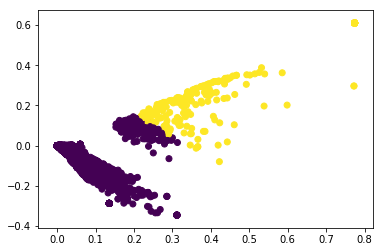

Comparing k-means clusters against the data:
screenname  HillaryClinton  justinbieber  katyperry  realDonaldTrump
row_0                                                               
0                     2519          1886       2832             2792
1                       19           116         24               75


In [44]:
# We are limiting our feature space to 2 components here. 
#  This makes it easier to graph and see the clusters.
svd= TruncatedSVD(2)

# Normalize the data.
X_norm = normalize(X_tfidf)

# Reduce it to two components.
X_svd = svd.fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))

So it looks like K-means is not breaking out tweets into two groups based on political or pop music content.  Most of the tweets, regardless of the tweeter, falls in one cluster.  Interestingly, Justin Bieber has the most tweets in the second cluster.  

### 3 clusters

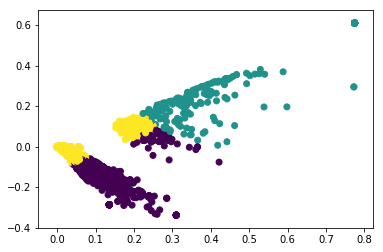

Comparing k-means clusters against the data:
screenname  HillaryClinton  justinbieber  katyperry  realDonaldTrump
row_0                                                               
0                     1286           338        178              910
1                       15           113         23               64
2                     1237          1551       2655             1893


In [45]:
# We are limiting our feature space to 2 components here. 
#  This makes it easier to graph and see the clusters.
svd= TruncatedSVD(2)

# Normalize the data.
X_norm = normalize(X_tfidf)

# Reduce it to two components.
X_svd = svd.fit_transform(X_norm)

# Calculate predicted values.
y_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))

If we break it up into three clusters, we see that Hillary Clinton and Donald Trump tweets are more prevalent in the first cluster.  It is possible that this first cluster is the "politics" cluster.  The second cluster is made up of mostly Bieber tweets.  There seems to be something that separates Bieber tweets from the rest.  It's also interesting that Clinton tweets are pretty evenly split between the first and third clusters, while the rest have most of their tweets in the third cluster. 

### 4 clusters

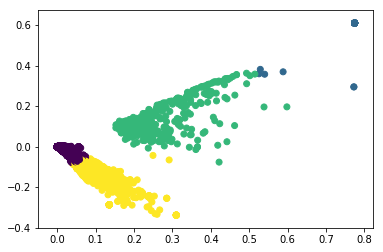

Comparing k-means clusters against the data:
screenname  HillaryClinton  justinbieber  katyperry  realDonaldTrump
row_0                                                               
0                     1228          1543       2634             1823
1                        1            36          3               12
2                       33            92         44              166
3                     1276           331        175              866


In [46]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(X_svd)

# Plot the solution.
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, Y))



Again, Clinton tweets fall in the first two clusters while the rest of the tweeters have the majority of their tweets in the first cluster.  Clinton and Trump tweets make up the majority of the second cluster.  Trump tweets make up half of the third cluster.   

There are other clustering algorithms we can employ, especially since the assumptions of k-means may indicate that it is not the best fit for our Twitter data.  First of all, k-means assume that the clusters are the same size.  While we have about equal number of tweets from each twitter account, it is clear from the graphs that the clusters are not the same size.  Additionally, k-means assume that the clusters are radially symmetrical (isotropic), meaning the clusters are uniform in all directions and have edges that curve outward.  Lastly, k-means assumes that the clusters have similar variances.  The graphs show that the clusters are neither radially symmetrical nor have similar variances.  

Let's try a different clustering algorithm: Mean-Shift.

<a id='meansshift'></a>
## Mean-shift clustering
Mean-shift works by calculating the probability that a datapoint will be present at any point in an n-dimensional space, forming a kernel density surface.  Areas with "hills" have a high concentration of datapoints.  Flat areas or valleys have very few data points.  Then, each data point is iteratively shifted "up" a tiny bit the nearest hill.  Once all the data points have reached their peaks and any further shifts are smaller than a given thresholds, the algorithm ends and the data points are assigned a cluster based on their peak. 

Mean-shift clustering is more flexible than k-means, because it does not assume that the clusters have to be the same size or radially symmetric.  The clusters can have non-flat geometry.  We can also use mean-shift to predict how many clusters to look for!  This may give us more insight into how the tweets are clustered.

In [47]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_svd, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_svd)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 24


Wow, that's a lot of clusters.   Let's take a look at what that looks like visually.

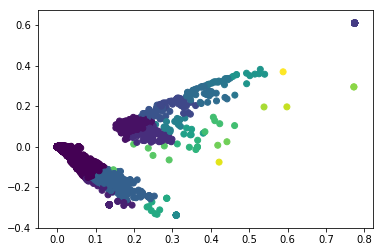

Comparing the assigned categories to the ones in the data:
col_0              0   1   2   3   4   5   6    7   8   9  ...  14  15  16  \
screenname                                                 ...               
HillaryClinton   2242  10  11   8   1   2   7  247   0   3 ...   4   0   0   
justinbieber     1764  10  55   5  32  18  13   50  24  10 ...   4   1   1   
katyperry        2790  23   5   1   2   6   5   14   5   1 ...   0   0   0   
realDonaldTrump  2516  69   2  36  11  10  11  152   5   4 ...   2   5   4   

col_0            17  18  19  20  21  22  23  
screenname                                   
HillaryClinton    0   0   0   0   0   0   0  
justinbieber      1   0   2   0   0   0   0  
katyperry         0   0   0   0   0   0   1  
realDonaldTrump   6   2   0   1   1   1   0  

[4 rows x 24 columns]


In [48]:
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(Y,labels))

From our table, we can see that a lot of the clusters only contain 1 or 2 tweets.  Still, most tweets seem to reside in the first cluster. It doesn't look like mean-shift is much more effective at grouping our tweets than k-means was.

<a id='lsa'></a>
## Latent Semantic Analysis

Though reducing our space to two vectors allow us to visualize our clusters on a 2-D plane, it may be too limiting.  Let's increase our feature space to 200.  We won't be able to visuallize it, but with Latent Semantic Analysis we can see the topics that are generated from our corpus.

In [49]:
#Our SVD data reducer.  We are going to reduce the feature space to 200 components.
svd= TruncatedSVD(200)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_lsa = lsa.fit_transform(X_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100, '\n')

#Looking at what sorts of tweets our solution considers similar, for the first five identified topics
paras_by_component=pd.DataFrame(X_lsa, index=X)
for i in range(10):
    print('Component {}:'.format(i))
    print(paras_by_component.loc[:,i].sort_values(ascending=False)[0:10])
    print('\n')


Percent variance captured by all components: 32.387547767090815 

Component 0:
tweet
#PurposeTourGlendale another great show. Thank u    0.779816
Great show. Thank you                               0.779816
Thank you #mybeliebers                              0.777688
@ladygaga thank u for the kindness                  0.777111
Thank you Nashville, Tennessee!                     0.776522
Thank you                                           0.776248
Thank u                                             0.776248
Thank you                                           0.776248
Thank you                                           0.776248
Thank you                                           0.776248
Name: 0, dtype: float64


Component 1:
tweet
Thank u                         0.612488
Thank you                       0.612488
Thank you Nicole!               0.612488
Thank you                       0.612488
Thank you!                      0.612488
Thank u #PurposeTourSanDiego    0.612488
Thank you     

SVD compresses features into independent components that are not correlated with any other components.  We are going to lose some of the information due to this compression.  But we can explain 32% of the variance. 

The first three components have to do with thanks.  The fourth and fifth components is around "love".  Sixth component are tweets that contain "lol". Seventh component is made up of tweets about Donald Trump.  Eighth component has the word "purpose", which is the title of Justin Beiber's new album.   THe ninth component is a little confusing. There are some Hillary Clinton tweets and some #Purpose tweets. The final cluster is about American Idol, which currently stars Katy Perry. 

In summary, some of the clusters do focus more on one twitter handle over the others. #Purpose is mostly Justin Beiber.  #AmericanIdol is Katy Perry.  Other tweets topics, e.g. those expressing thanks, are more ubiquitous.

<a id='conclude2'></a>
## Unsupervised Learning Conclusion

<a id='word'></a>
# Word2vec
Word2vec is the most common unsupervised neural network approach for NLP.  It converts words to vectors using distributed representation, where each word is represented by many neurons, and each neuron represents multiple words.  word2vec is powerful because it assigns a vector of random values to each word W, then shifts the vectors for the words around W in the sentence.  Words that are close to W have vectors that are closer together, while words that are not near W have vectors that are also far away.  Word2vec is great for tweets because tweets can contain the same concepts written in many different ways (e.g. expressing thanks).

We do need are larger corpus when using word2vec.  So first, let's generate more tweets!

In [50]:
# Getting more tweets from Ellen Degeneres, Barack Obama, Rihanna, Senator John Mccain, and Pope Francis
more_twts = get_all_tweets(['TheEllenShow','BarackObama','Rihanna','senjohnmccain','pontifex'])

getting tweets before 991007542498086914
...400 tweets downloaded so far
getting tweets before 980920147828293631
...600 tweets downloaded so far
getting tweets before 968657293888839679
...800 tweets downloaded so far
getting tweets before 959844632090722303
...1000 tweets downloaded so far
getting tweets before 953446632741158911
...1200 tweets downloaded so far
getting tweets before 943915391377641474
...1400 tweets downloaded so far
getting tweets before 935224030608613375
...1600 tweets downloaded so far
getting tweets before 926176839189479423
...1800 tweets downloaded so far
getting tweets before 918203705500958719
...2000 tweets downloaded so far
getting tweets before 910183648543965183
...2200 tweets downloaded so far
getting tweets before 900491419185324031
...2400 tweets downloaded so far
getting tweets before 872220989421101055
...2600 tweets downloaded so far
getting tweets before 860218128541687807
...2800 tweets downloaded so far
getting tweets before 850058836991922175


In [51]:
more_twts[0].value_counts()

TheEllenShow     3249
BarackObama      3205
SenJohnMcCain    3203
rihanna          3158
Pontifex         1584
Name: 0, dtype: int64

In [52]:
more_twts.columns = ['screenname','tweet']

In [53]:
more_twts['tweet'] = more_twts['tweet'].astype(str)


In [54]:
for r in range(len(tweets['tweet'])):
    more_twts['tweet'][r] = text_cleaner(more_twts['tweet'][r])

#Dropping retweets    
more_twts = more_twts[more_twts['tweet'].str.contains("RT") == False].reset_index(drop=True)

In [55]:
# Parse tweets
nlp = spacy.load('en')

parsed = []

for r in more_twts['tweet']:
    p = nlp(r)
    parsed.append(p)

In [56]:
more_twts['parsed'] = parsed

In [57]:
# Adding tweets from previous pull to dataframe.
df = pd.concat([more_twts, tweets], axis=0)

In [58]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23536 entries, 0 to 23535
Data columns (total 3 columns):
screenname    23536 non-null object
tweet         23536 non-null object
parsed        23536 non-null object
dtypes: object(3)
memory usage: 551.7+ KB


In [59]:
# Organize the parsed doc into sentences, while filtering out punctuation
# and stop words, and converting words to lower case lemmas.
twts = []
for tweet in df['parsed']:
    tweet = [
        token.lemma_.lower()
        for token in tweet
        if not token.is_stop
        and not token.is_punct
    ]
    twts.append(tweet)


print(twts[10])
print('We have {} tweets and {} tokens.'.format(len(twts), len(text)))

['.@official_twitch', 'help', 'sweet', 'guy', 'propose', 'absolutely', 'go', 'weekend', 'twitchplease']
We have 23536 tweets and 169542 tokens.


In [60]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    twts,
    workers=4,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=10,  # Minimum word count threshold.
    window=6,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-3 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('done!')

done!


In [61]:
# List of words in model.
vocab = model.wv.vocab.keys()

print(vocab)

dict_keys(['-pron-', '’', 'love', 'amazing', 'proposal', '@official_twitch', 'pull', 'couple', 'thank', 'make', 'p', 'just', 'order', 'vacation', 'quick', 'question', 'who', 'like', 'good', 'deal', 'have', 'little', 'rehearsal', 'army', 'follower', 'even', 'express', 'fan', 'thankssponsor', 'btsxellen', 'go', 'to', 'teach', 'baby', 'how', '❤', '️', 'help', 'sweet', 'guy', 'propose', 'absolutely', 'weekend', 'play', 'what', 'hear', 'raise', 'hand', 'real', '@bts_twt', 'happy', 'birthday', 'ask', 'lady', '’s', 'scar', 's', 'bts', '\n\n', 'watch', 'clip', 'check', 'exclusive', 'trailer', 'debut', 'right', 'august', 'believe', 'happen', 'tomorrow', ' ', '5th', '@headsup', 'exciting', 'new', 'update', 'tonight', '@nbc', 'do', 'not', 'donate', 'adorable', 'kid', 'but', 'now', 'know', 'exactly', 'be', 'get', 'twin', 'tell', 'beautiful', 'reason', 'change', 'think', 'incredible', 'would', 'season', 'people', '10', 'year', 'favorite', 'far', 'here', 'look', 'sure', '@edwildlifefund', 'if', 'mea

In [62]:
print(model.wv.most_similar(positive=['crooked', 'honest'], negative=['dishonest']))

# Similarity is calculated using the cosine, so again 1 is total
# similarity and 0 is no similarity.
print(model.wv.similarity('💄', '👠'))
print(model.wv.similarity('repeal', 'delay'))
print(model.wv.similarity('laugh', 'joy'))

# One of these things is not like the other...
print(model.doesnt_match("💪 🙌 🍕 👏".split()))
print(model.doesnt_match("phony dishonest crooked forgiveness".split()))

[('9:00', 0.7895216941833496), ('clinton', 0.736916184425354), ('8/7c', 0.7279561758041382), ('@nbc', 0.7056699991226196), ('cast', 0.6953930854797363), ('littlebigshot', 0.6950119733810425), ('47246', 0.6933400630950928), ('gameofgames', 0.6930747628211975), ('demsinphilly', 0.6830839514732361), ('stage', 0.6798983812332153)]
0.809544089347198
0.698721578835333
0.49064126311857414
👏
forgiveness


Because word2vec requires a corpus of several billion words, this model is not very accurate.  In the analogy of crooked is to dishonest as honest is to (blank), the model generated some nonsense answers (9:00, @nbc, stage).  The model did pick up on the similarities between the lipstick and high heel show emoji, but not the similarities between laugh and joy.  It was able to find "forgiveness" as the odd one out, but not the pizza emoji.

<a id='conclude3'></a>
# Conclusion